<a href="https://colab.research.google.com/github/AlexandreAdam/Censai/blob/eager2.4/notebooks/train_rim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AlexandreAdam/Censai.git
%cd Censai
!git checkout eager2.4 
!python setup.py install
!pip install wandb

fatal: destination path 'Censai' already exists and is not an empty directory.
/content/Censai
Already on 'eager2.4'
Your branch is up to date with 'origin/eager2.4'.
running install
running bdist_egg
running egg_info
writing censai.egg-info/PKG-INFO
writing dependency_links to censai.egg-info/dependency_links.txt
writing top-level names to censai.egg-info/top_level.txt
writing manifest file 'censai.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/censai
copying build/lib/censai/__init__.py -> build/bdist.linux-x86_64/egg/censai
copying build/lib/censai/data_generator.py -> build/bdist.linux-x86_64/egg/censai
copying build/lib/censai/utilities.py -> build/bdist.linux-x86_64/egg/censai
copying build/lib/censai/definitions.py -> build/bdist.linux-x86_64/egg/censai
copying build/lib/censai/physical_model.py -> build/bdist.linux-x86_64/egg/censai
byt

In [2]:
# wanb login
%pip install wandb -q
%pip install tensorflow_addons
import wandb


In [4]:
import tensorflow as tf
from censai.physical_model import PhysicalModel
from censai.data_generator import NISGenerator
from censai.definitions import RIM_UNET_CELL
from censai.utilities import nullwriter
import os
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
%matplotlib inline
# os.mkdir("logs") # run only once/

In [5]:
def main(args):
    if wndb:
          config = wandb.config
          config.learning_rate = args.lr
          config.batch_size = args.batch_size
          config.epochs = args.epochs
          config.architecture="Double RIM Unet"
          config.update(args)
    gen = NISGenerator(args.total_items, args.batch_size, model="rim", pixels=args.pixels) #TODO add noise to observed lens
    gen_test = NISGenerator(args.validation, args.validation, train=False, model="rim", pixels=args.pixels)
    phys = PhysicalModel(pixels=args.pixels, noise_rms=args.noise_rms)
    rim = RIM_UNET_CELL(phys, args.batch_size, args.time_steps, args.pixels)
    optim = tf.optimizers.Adam(args.lr)
	# setup tensorboard writer (nullwriter in case we do not want to sync)
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, args.logname)
        traindir = os.path.join(logdir, "train")
        testdir = os.path.join(logdir, "test")
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        if not os.path.isdir(traindir):
            os.mkdir(traindir)
        if not os.path.isdir(testdir):
            os.mkdir(testdir)
        train_writer = tf.summary.create_file_writer(traindir)
        test_writer = tf.summary.create_file_writer(testdir)
    else:
        test_writer = nullwriter()
        train_writer = nullwriter()

    epoch_loss = tf.metrics.Mean()
    best_loss = np.inf
    patience = args.patience
    step = 1
    # if args.kappalog:
    #     link = lambda x: tf.math.log(x + 1e-16) / np.log(10.)
    #     invlink = lambda x: 10.**(x)
    # else:
    #     link = lambda x: x
    #     invlink = lambda x: x
    step = 1
    for epoch in range(args.epochs):
        epoch_loss.reset_states()
        with train_writer.as_default():
            for batch, (X, source, kappa) in enumerate(gen):
                with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:
                    tape.watch(rim.model_1.trainable_variables)
                    tape.watch(rim.model_2.trainable_variables)
                    cost = rim.cost_function(X, source, tf.math.log(kappa + 1e-10) / tf.math.log(10.))
                gradient1 = tape.gradient(cost, rim.model_1.trainable_variables)
                gradient2 = tape.gradient(cost, rim.model_2.trainable_variables)
                # clipped_gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
                optim.apply_gradients(zip(gradient1, rim.model_1.trainable_variables)) # backprop
                optim.apply_gradients(zip(gradient2, rim.model_2.trainable_variables))

                #========== Summary and logs ==========
                epoch_loss.update_state([cost])
                tf.summary.scalar("MSE", cost, step=step)
                step += 1
            # tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
        with test_writer.as_default():
            for (X, source, kappa) in gen_test:
                test_cost = rim.cost_function(X, source,  tf.math.log(kappa + 1e-10) / tf.math.log(10.))
            tf.summary.scalar("MSE", test_cost, step=step)
        print(f"epoch {epoch} | train loss {epoch_loss.result().numpy():.3e} | val loss {test_cost.numpy():.3e}") #| learning rate {optim.lr(step).numpy():.2e}")
        if test_cost < best_loss - args.tolerance:
            best_loss = test_cost
            patience = args.patience
        else:
            patience -= 1
        if patience == 0:
            print("Reached patience")
            break
    return gen, gen_test, rim, epoch_loss.result()

In [6]:
# quick hack to make a config like args of ArgumentParser
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

lr = 1e-6
decay_steps=100
decay_rate=1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)
init_range = 0.1
# initializer = tf.keras.initializers.RandomUniform(minval=-init_range, maxval=init_range)
# initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=init_range)
initializer = tf.keras.initializers.GlorotNormal()
# setup hyperparameter and other configs
date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
Config = AttrDict()
Config.update({
    #hparams
    "epochs": 10,
    "lr": lr, # initial learning rate
    "decay_steps": decay_steps,
    "decay_rate": decay_rate,
    "batch_size": 1,
    "kappalog": True,
    "clipping": False,
    "pixels": 64,
    "noise_rms": 0.1,
    "time_steps": 16,
    # "initializer_range":init_range,
    "initializer_type": "glorot_normal",
    "optimizer_name": "Adam",
    #configs
    "total_items": 10, # items per epochs
    "logdir": "none",
    "logname": date,
    "validation": 10,
    "patience": np.inf,
    "tolerance": 0,
    # "schedule": lr_schedule,
    "initializer": initializer,
    "optimizer": tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    "note": "Data generator updated parameter space. x_c does not vary anymore, fixed t0 0.001"

})


In [ ]:
wndb = False
# wandb.init(project="censai", entity="adam-alexandre01123", sync_tensorboard=True)
gen, gen_test, rim, loss = main(Config)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


Text(0.5, 1.0, 'Kappa')

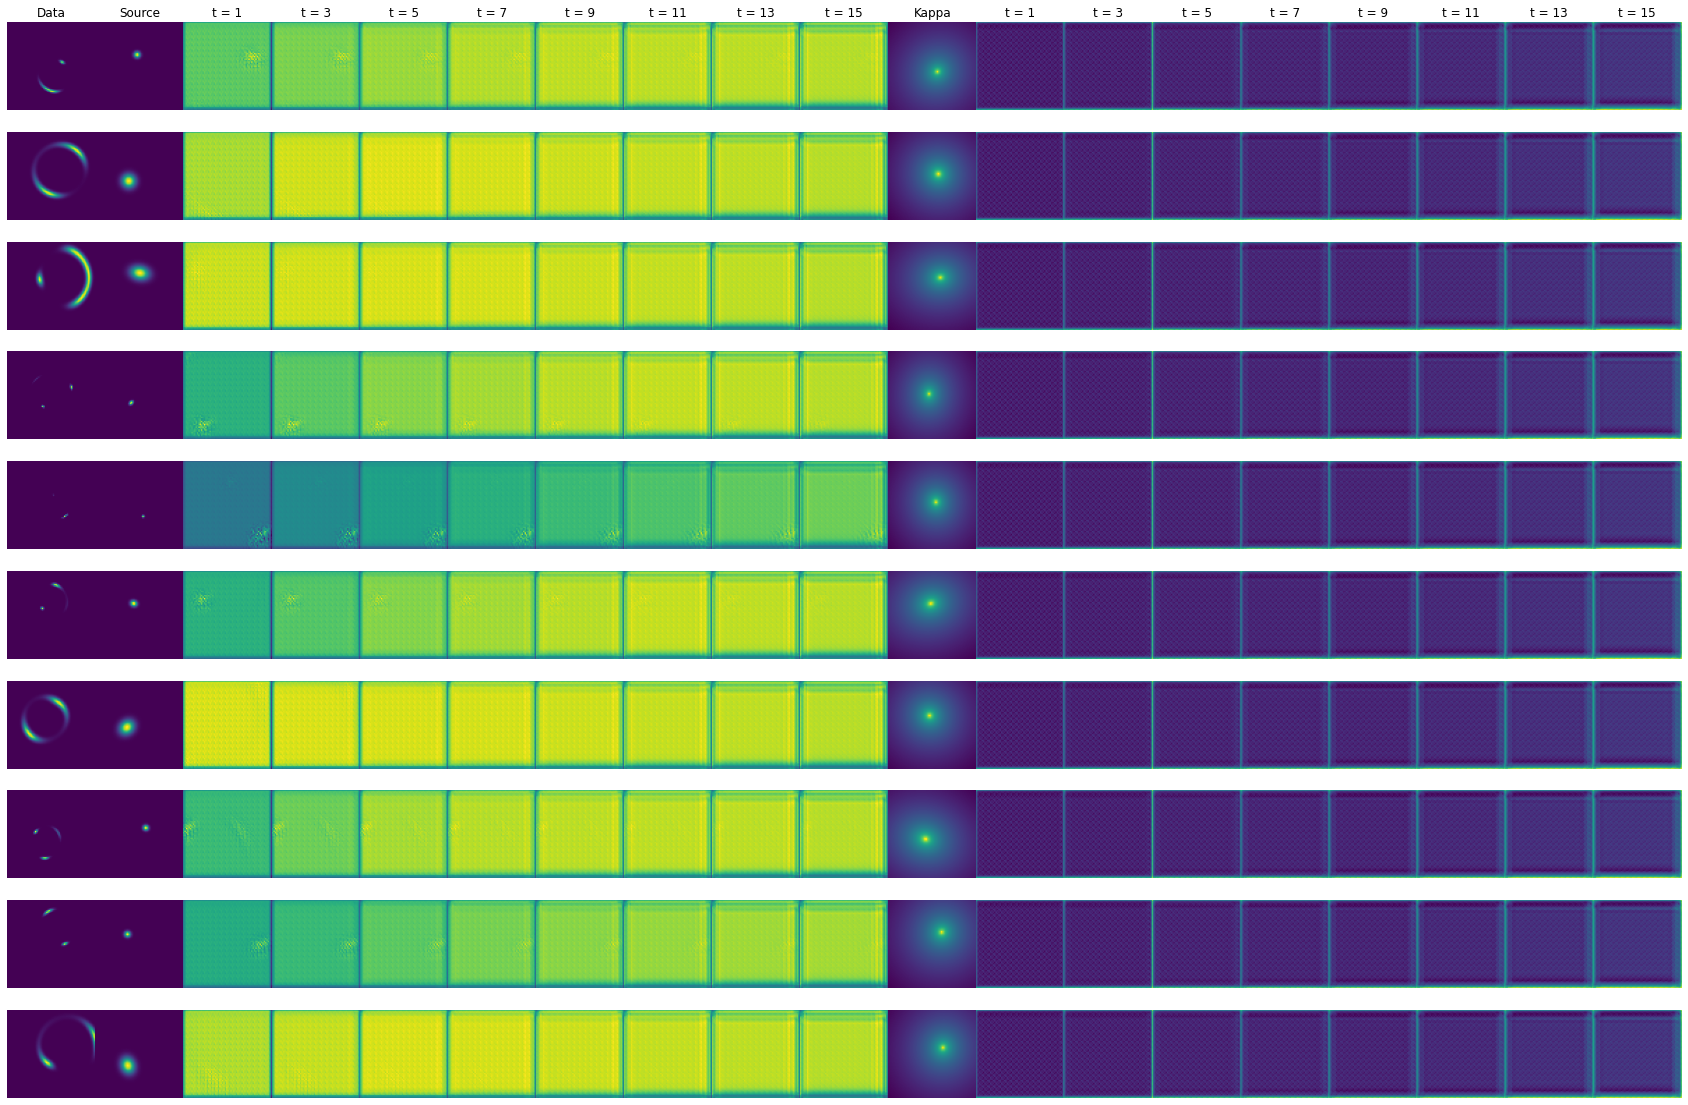

In [31]:
fig, axs = plt.subplots(10, 19, figsize=(30, 20), squeeze=True, gridspec_kw={'wspace':0, 'hspace':0.1})
fig.tight_layout()
for i in range(10):
    X, source, kappa = gen[i]
    source_pred, kappa_pred, cost = rim.forward_pass(X)
    axs[i, 0].imshow(X.numpy()[0, ..., 0], origin="lower")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(source.numpy()[0, ..., 0], origin="lower")
    axs[i, 1].axis("off")
    for j in range(8):
        axs[i, 2+j].imshow(source_pred[2*j+1][0, ..., 0], origin="lower")
        axs[i, 2+j].axis("off")
        if i == 0:
            axs[0, 2+j].set_title(f"t = {2*j+1}")

    axs[i, 3+j].imshow( tf.math.log(kappa.numpy()[0, ..., 0] + 1e-10) / tf.math.log(10.), origin="lower")
    axs[i, 3+j].axis("off")
    for k in range(8):
        axs[i, 4+j+k].imshow(kappa_pred[2*k+1].numpy()[0, ..., 0], origin="lower")
        axs[i, 4+j+k].axis("off")
        if i == 0:
            axs[0, 4+j+k].set_title(f"t = {2*k+1}")    

axs[0, 0].set_title("Data")
axs[0, 1].set_title("Source")

axs[0, 3+j].set_title("Kappa")


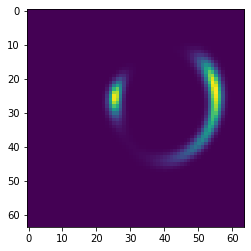

Text(0.5, 1.0, 'Prediction')

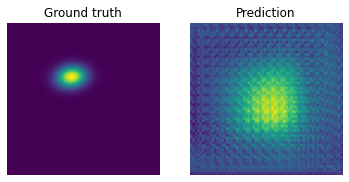

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(source.numpy()[0, ..., 0])
ax1.axis("off")
ax1.set_title("Ground truth")
ax2.imshow(source_pred[-1].numpy()[0, ..., 0])
ax2.axis("off")
ax2.set_title("Prediction")

Text(0.5, 1.0, 'Prediction')

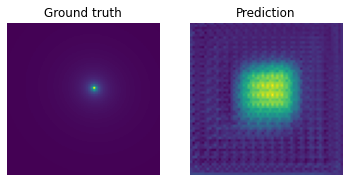

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(kappa.numpy()[0, ..., 0])
ax1.axis("off")
ax1.set_title("Ground truth")
ax2.imshow(kappa_pred[-1].numpy()[0, ..., 0])
ax2.axis("off")
ax2.set_title("Prediction")

In [13]:
kappa

NameError: ignored